### Display last self-attention 
* https://github.com/huggingface/pytorch-image-models/discussions/1232
* https://gitlab.com/ziegleto-machine-learning/dino/-/tree/main/

In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import Compose, Resize, CenterCrop, Normalize, ToTensor
from torchvision import transforms as pth_transforms
from utils_dir.backbones_utils import extract_backbone_features, load_backbone

/home/gridsan/manderson/.conda/envs/test/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [53]:
def to_tensor(img, patch_size):
    #transform_fn = Compose([Resize(249, 3), CenterCrop(224), ToTensor(), Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    #return transform_fn(img)
    transform = pth_transforms.Compose([
    pth_transforms.ToTensor(),
    pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
    img = transform(img)
    w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
    img = img[:, :w, :h]
    return img

def show_img(img):
    img = np.asarray(img)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def show_img2(img1, img2, alpha=0.8):
    img1 = np.asarray(img1)
    img2 = np.asarray(img2)
    plt.figure(figsize=(10, 10))
    plt.imshow(img1)
    plt.imshow(img2, alpha=alpha)
    plt.axis('off')
    plt.show()

def my_forward_wrapper(attn_obj):
    def my_forward(x):
    
        
        B, N, C = x.shape
        qkv = attn_obj.qkv(x).reshape(B, N, 3, attn_obj.num_heads, C // attn_obj.num_heads).permute(2, 0, 3, 1, 4)

        q, k, v = qkv[0] * attn_obj.scale, qkv[1], qkv[2]
        attn = q @ k.transpose(-2, -1)

        #attn = attn.softmax(dim=-1)
        attn = attn_obj.attn_drop(attn)
        attn_obj.attn_map = attn

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = attn_obj.proj(x)
        x = attn_obj.proj_drop(x)
        '''
        B, N, C = x.shape
        qkv = attn_obj.qkv(x).reshape(B, N, 3, attn_obj.num_heads, C // attn_obj.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * attn_obj.scale
        attn = attn.softmax(dim=-1)
        attn = attn_obj.attn_drop(attn)
        attn_obj.attn_map = attn

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = attn_obj.proj(x)
        x = attn_obj.proj_drop(x)
        '''
        
        return x

    return my_forward

In [5]:
'''
B, N, C = x.shape
qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
q, k, v = qkv[0], qkv[1], qkv[2]

attn = (q @ k.transpose(-2, -1)) * self.scale
attn = attn.softmax(dim=-1)
attn = self.attn_drop(attn)

x = (attn @ v).transpose(1, 2).reshape(B, N, C)
x = self.proj(x)
x = self.proj_drop(x)
return x, attn
'''

'\nB, N, C = x.shape\nqkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)\nq, k, v = qkv[0], qkv[1], qkv[2]\n\nattn = (q @ k.transpose(-2, -1)) * self.scale\nattn = attn.softmax(dim=-1)\nattn = self.attn_drop(attn)\n\nx = (attn @ v).transpose(1, 2).reshape(B, N, C)\nx = self.proj(x)\nx = self.proj_drop(x)\nreturn x, attn\n'

In [ ]:
# Load backbone
model = load_backbone('dinov2') 
model.blocks[-1].attn.forward = my_forward_wrapper(model.blocks[-1].attn)
num_heads = model.blocks[0].attn.num_heads
print(num_heads, 'attention heads')

Using cache found in /home/gridsan/manderson/.cache/torch/hub/facebookresearch_dinov2_main


In [ ]:
# Load and format image
patch_size = model.patch_embed.patch_size[0]
print('patch size:', patch_size)
img = Image.open('/home/gridsan/manderson/ovdsat/data/simd/val/4220.jpg')
plt.imshow(img)
x = to_tensor(img, patch_size)
print(x.shape) #torch.Size([1, 3, 756, 1022])
w_featmap = x.shape[-2] // patch_size
h_featmap = x.shape[-1] // patch_size
print('Feature size:', w_featmap, h_featmap)

In [48]:
# Pass image and extract attention maps
y = model(x.unsqueeze(0))
attn_maps = model.blocks[-1].attn.attn_map.squeeze(0)
print(attn_maps.shape) # (feat_w * feat_h) + 1 (cls)

torch.Size([16, 3943, 3943])


In [49]:
attn_try = attn_maps[:,-1,:-1].reshape(num_heads, w_featmap, h_featmap).cpu().numpy()
print(attn_try.shape)
attn_try_mean = np.mean(attn_try, axis=0)
print(attn_try_mean.shape)

(16, 54, 73)
(54, 73)


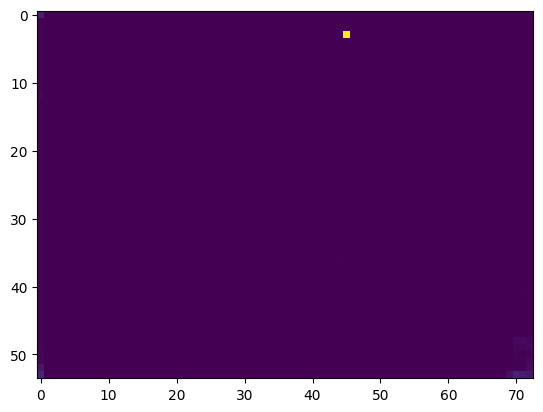

In [50]:
plt.imshow(attn_try_mean)

In [51]:
max_idx = np.argmax(attn_try_mean)
i,j = np.unravel_index(max_idx, (attn_try_mean.shape[0], attn_try_mean.shape[1]))
attn_try_mean[i,j] = 0

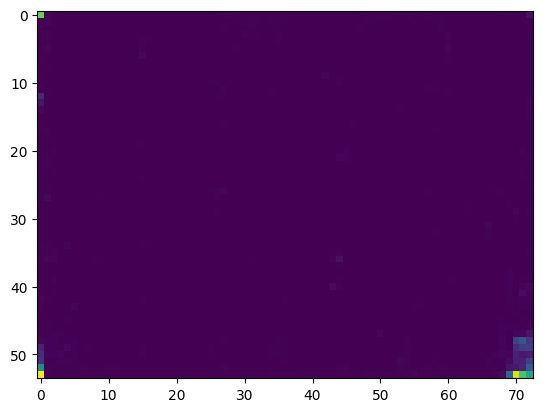

In [52]:
plt.imshow(attn_try_mean)

In [16]:
# Extract CLS attention to all other tokens
attn = attn_maps[:, 0, 1:].reshape(num_heads, w_featmap, h_featmap)
attn = nn.functional.interpolate(attn.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()
print(attn.shape)
attn_mean = np.mean(attn, axis=0)
print(attn_mean.shape)

(16, 476, 476)
(476, 476)


In [28]:
max_idx = np.argmax(attn_mean)
i,j = np.unravel_index(max_idx, (attn_mean.shape[0], attn_mean.shape[1]))
attn_mean[i,j] = 0

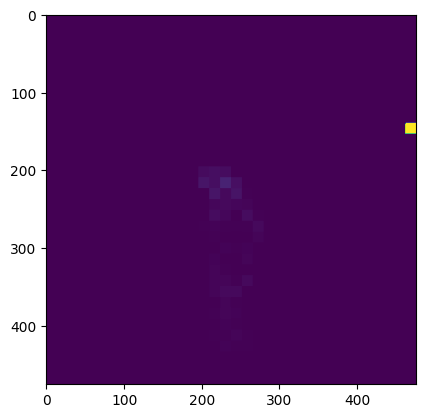

In [29]:
plt.imshow(attn_mean)